/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 235MB/s]


Epoch 1/10, Loss: 1.2565
Epoch 2/10, Loss: 0.3571
Epoch 3/10, Loss: 0.2046
Epoch 4/10, Loss: 0.1248
Epoch 5/10, Loss: 0.0605
Epoch 6/10, Loss: 0.0198
Epoch 7/10, Loss: 0.0079
Epoch 8/10, Loss: 0.0078
Epoch 9/10, Loss: 0.0593
Epoch 10/10, Loss: 0.0281


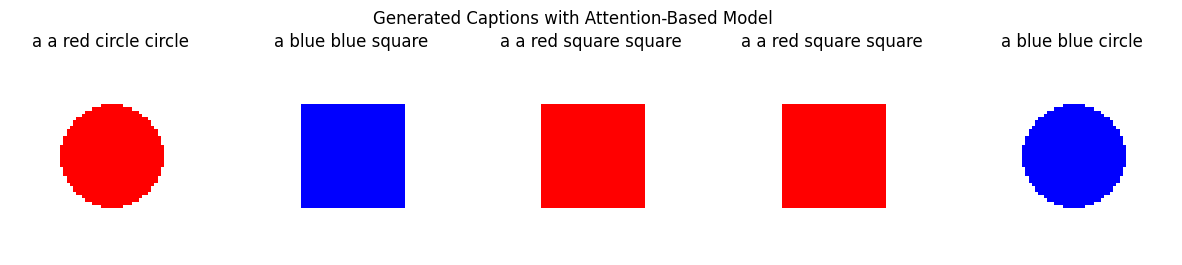

In [2]:
# Image Captioning with Attention (Show, Attend, and Tell)

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
import random

# Dummy captioned image dataset for teaching purposes
class ToyCaptionDataset(Dataset):
    def __init__(self, transform=None):
        self.imgs = []
        self.captions = []
        self.transform = transform
        shapes = ['circle', 'square']
        colors = ['red', 'blue']
        for _ in range(200):
            color = random.choice(colors)
            shape = random.choice(shapes)
            caption = f"a {color} {shape}"
            img = self.generate_image(color, shape)
            self.imgs.append(img)
            self.captions.append(caption)

    def generate_image(self, color, shape):
        img = Image.new('RGB', (64, 64), 'white')
        draw = ImageDraw.Draw(img)
        fill = color
        if shape == 'circle':
            draw.ellipse((16, 16, 48, 48), fill=fill)
        else:
            draw.rectangle((16, 16, 48, 48), fill=fill)
        return img

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.transform(self.imgs[idx]) if self.transform else self.imgs[idx]
        return img, self.captions[idx]

# Vocabulary and tokenizer
class Vocab:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>"}
        self.idx = 3

    def add_sentence(self, sentence):
        for word in sentence.lower().split():
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def numericalize(self, sentence):
        return [1] + [self.word2idx[word] for word in sentence.lower().split()] + [2]

    def decode(self, idxs):
        return ' '.join([self.idx2word[i] for i in idxs if i not in {0, 1, 2}])

# CNN Encoder (ResNet18 backbone)
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]  # Remove FC layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(512, embed_size)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)  # [B, 512, 2, 2]
        features = features.mean([2, 3])  # Global average pooling
        features = self.fc(features)
        return features

# RNN Decoder with Attention
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings[:, :-1, :]), dim=1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.fc(hiddens)
        return outputs

# Training setup
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = ToyCaptionDataset(transform=transform)
vocab = Vocab()
for _, cap in dataset:
    vocab.add_sentence(cap)

def collate_fn(batch):
    imgs, caps = zip(*batch)
    imgs = torch.stack(imgs)
    caps = [torch.tensor(vocab.numericalize(c)) for c in caps]
    caps = nn.utils.rnn.pad_sequence(caps, batch_first=True, padding_value=0)
    return imgs, caps

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

encoder = EncoderCNN(embed_size=128)
decoder = DecoderRNN(embed_size=128, hidden_size=256, vocab_size=len(vocab.word2idx))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder, decoder = encoder.to(device), decoder.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

# Training loop
for epoch in range(10):
    total_loss = 0
    for imgs, caps in dataloader:
        imgs, caps = imgs.to(device), caps.to(device)
        features = encoder(imgs)
        outputs = decoder(features, caps)
        loss = criterion(outputs.view(-1, outputs.size(-1)), caps.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss / len(dataloader):.4f}")

# Inference
encoder.eval()
decoder.eval()

def generate_caption(image):
    with torch.no_grad():
        image = transform(image).unsqueeze(0).to(device)
        feature = encoder(image)
        caption = [1]  # <SOS>
        for _ in range(10):
            cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)
            out = decoder(feature, cap_tensor)
            next_word = out.argmax(2)[0, -1].item()
            if next_word == 2:  # <EOS>
                break
            caption.append(next_word)
        return vocab.decode(caption)

# Visualization
import matplotlib.pyplot as plt
from PIL import ImageDraw

def visualize_results():
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, _ = dataset[i]
        caption = generate_caption(dataset.imgs[i])
        axs[i].imshow(dataset.imgs[i])
        axs[i].set_title(caption)
        axs[i].axis('off')
    plt.suptitle("Generated Captions with Attention-Based Model")
    plt.show()

visualize_results()
